+---+-----+-----+-----+-----+-----+-----+
| A | aaa | bbb | ccc | ddd | eee | fff |
| B | aaa | bbb | eex | -   | -   | fff |
+---+-----+-----+-----+-----+-----+-----+


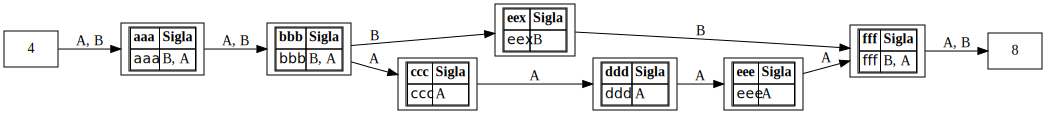

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/Users/djb/collatex/collatex-pythonport')  # CollateX from repo if not installed
from collatex import *
collation = Collation()
collation.add_plain_witness("A", "aaa bbb ccc ddd eee fff")
collation.add_plain_witness("B", "aaa bbb eex fff")
# collation.add_plain_witness("C", "aaa bbb eex ddd fff")
# collation.add_plain_witness("D", "aaa aaa aaa aaa aaa")
table = collate(collation, segmentation=False, near_match=False)
print(table)
collate(collation, segmentation=False, output="svg", near_match=False)

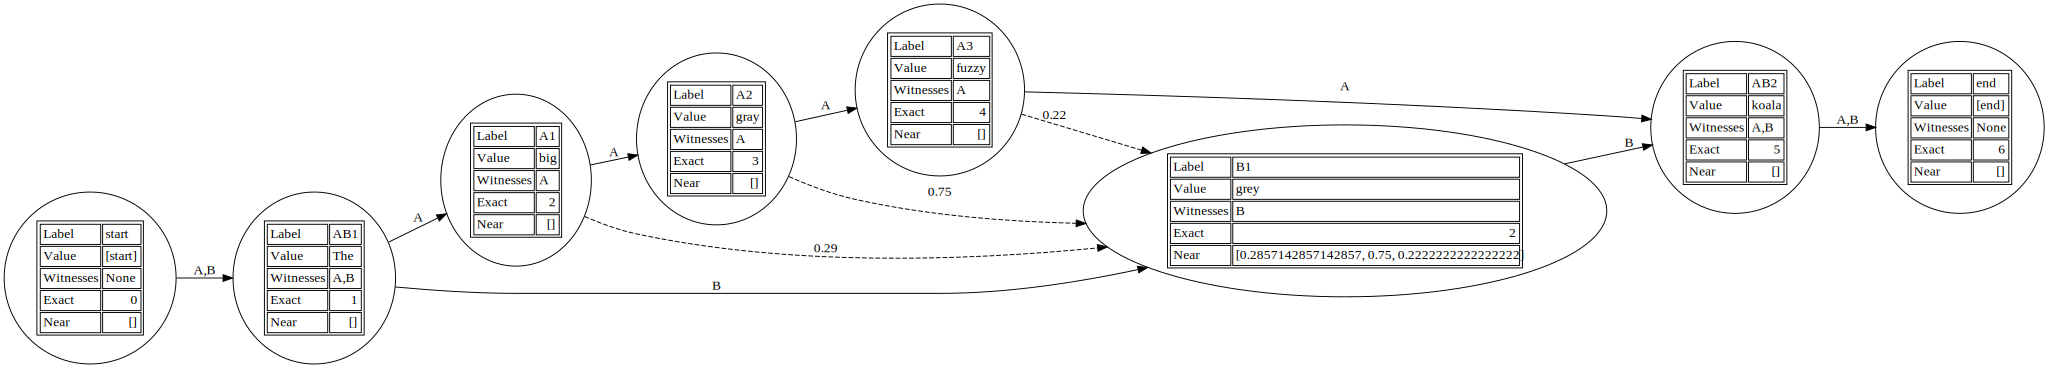

In [78]:
import networkx as nx
# import matplotlib.pyplot as plt
from networkx.algorithms.dag import topological_sort
import Levenshtein
from graphviz import Digraph
from IPython.core.display import SVG, display

"""\
A: The big gray  fuzzy koala
B: The     grey        koala
   AB1 A1  A2/B1 A3    AB2
"""

# Modified from core_classes.py
class VariantGraphRanking(object):
    # Do not class the constructor, use the of class method instead!
    def __init__(self):
        # Note: A vertex can have only one rank
        # however, a rank can be assigned to multiple vertices
        self.byVertex = {}
        self.byRank = {}

    def apply(self, vertex):
        return self.byVertex[vertex]

    @classmethod
    def of(cls, graph):
        variant_graph_ranking = VariantGraphRanking()
        topological_sorted_vertices = topological_sort(graph)
        for v in topological_sorted_vertices:
            in_ranks = []
            for (source, target, data) in graph.in_edges(v, data=True):
                in_ranks.append(variant_graph_ranking.byVertex[source])
            rank = max(in_ranks) + 1 if in_ranks else 0
            variant_graph_ranking.byVertex[v] = rank
            variant_graph_ranking.byRank.setdefault(rank, []).append(v)
        return variant_graph_ranking


# http://stackoverflow.com/questions/15353087/
# programmatically-specifying-nodes-of-the-same-rank-within-networkxs-wrapper-for
def graphviz_layout_with_rank(G, prog = "neato", root = None, sameRank = [], args = ""):
    ## See original import of pygraphviz in try-except block
    ## See original identification of root through command line
    A = nx.to_agraph(G)
    for sameNodeHeight in sameRank:
        if type(sameNodeHeight) == str:
            print("node \"%s\" has no peers in its rank group" %sameNodeHeight)
        A.add_subgraph(sameNodeHeight, rank="same")
    A.layout(prog=prog, args=args)
    ## See original saving of each node location to node_pos 
    return node_pos


# Flatten a list of lists (goes only one level down)
def flatten(in_list):
    return [item for sublist in in_list for item in sublist]
    
    
# Construct a graph that could benefit from near matching
g = nx.DiGraph()
g.add_node('start')
g.add_node('end')
g.add_node('AB1',witness=['A','B'],value='The')
g.add_node('A1',witness=['A'],value='big')
g.add_node('A2',witness=['A'],value='gray')
g.add_node('A3',witness=['A'],value='fuzzy')
g.add_node('B1',witness=['B'],value='grey')
g.add_node('AB2',witness=['A','B'],value='koala')
# start and end edges for all witnesses
g.add_edges_from([('start','AB1'),('AB2','end')], witness=['A', 'B'])
# edges for witness A
g.add_edge('AB1','A1', witness=['A'])
g.add_edge('A1','A2',witness=['A'])
g.add_edge('A2','A3',witness=['A'])
g.add_edge('A3','AB2',witness=['A'])
# edges for witness B
g.add_edge('AB1', 'B1', witness=['B'])
g.add_edge('B1','AB2', witness=['B'])

# Construct a ranking table for the graph
ranking = VariantGraphRanking.of(g)

# Find the vertices with any edge source where 
#     rank(target) > rank(source) + 1
reverse_topological_sorted_vertices = topological_sort(g, reverse=True)
for v in reverse_topological_sorted_vertices:
    target_rank = ranking.byVertex[v]
    in_edges = g.in_edges(v)
    if len(in_edges) > 1:
        move_candidates = [in_edge[0] for in_edge in in_edges \
                           if target_rank > ranking.byVertex[in_edge[0]] + 1]
        for move_candidate in move_candidates:
            min_rank = ranking.byVertex[move_candidate]
            max_rank = target_rank - 1
            vertices_to_compare = flatten([ranking.byRank[r] for r in range(min_rank, max_rank + 1)])
            vertices_to_compare.remove(move_candidate)
            for vertex_to_compare in vertices_to_compare:
                ratio = Levenshtein.ratio(g.node[move_candidate]['value'], g.node[vertex_to_compare]['value'])
                g.add_edge(vertex_to_compare, move_candidate, weight=ratio, type='near')

# render the graph as SVG (from CollateX display_module.py)
dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})
counter = 0
mapping = {}
for n in g.nodes():
    counter += 1
    mapping[n] = str(counter)
    node_value = g.node[n]['value'] if g.node[n] else '[' + n + ']'
    node_witnesses = ",".join(g.node[n]['witness']) if g.node[n] else 'None'
    exact_rank = str(ranking.byVertex[n])
    # RESUME HERE; currently list of weights, instead of revised ranking based on max weight
    near_edges = str(([edge[2]['weight'] for edge in g.in_edges(n, data=True) if 'weight' in edge[2]]))
    label = '<<TABLE><TR><TD ALIGN="left">Label</TD><TD ALIGN="left">' + n + '</TD></TR>' + \
        '<TR><TD ALIGN="left">Value </TD><TD ALIGN="left">' + node_value + '</TD></TR>' + \
        '<TR><TD ALIGN="left">Witnesses</TD><TD ALIGN="left">' + node_witnesses + '</TD></TR>' + \
        '<TR><TD ALIGN="left">Exact</TD><TD ALIGN="right">' + exact_rank + '</TD></TR>' + \
        '<TR><TD ALIGN="left">Near</TD><TD ALIGN="right">' + near_edges + '</TD></TR>' + \
        '</TABLE>>'
    dot.node(mapping[n], label)
for u,v,edgedata in g.edges_iter(data=True):
    edge_witnesses = edgedata['witness'] if 'witness' in edgedata else '[non-witness edge]'
    label = str('{:3.2f}'.format(edgedata['weight'])) if 'weight' in edgedata else ",".join(edge_witnesses)
    dot.edge(str(mapping[u]), str(mapping[v]), style='dashed' if 'type' in edgedata else 'solid', \
             label=label)
    
svg = dot.render()
display(SVG(svg))

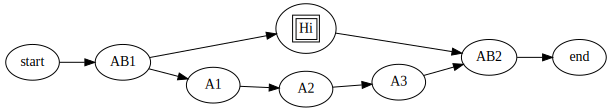

In [162]:
import networkx as nx
from IPython.core.display import SVG, display

# http://pygraphviz.github.io/documentation/latest/pygraphviz.pdf

g = nx.DiGraph()
g.add_node('start')
g.add_node('end')
g.add_node('AB1',witness=['A','B'],value='The')
g.add_node('A1',witness=['A'],value='big')
g.add_node('A2',witness=['A'],value='gray')
g.add_node('A3',witness=['A'],value='fuzzy')
g.add_node('B1',witness=['B'],value='grey')
g.add_node('AB2',witness=['A','B'],value='koala')
# start and end edges for all witnesses
g.add_edges_from([('start','AB1'),('AB2','end')], witness=['A', 'B'])
# edges for witness A
g.add_edge('AB1','A1', witness=['A'])
g.add_edge('A1','A2',witness=['A'])
g.add_edge('A2','A3',witness=['A'])
g.add_edge('A3','AB2',witness=['A'])
# edges for witness B
g.add_edge('AB1', 'B1', witness=['B'])
g.add_edge('B1','AB2', witness=['B'])

a = nx.drawing.nx_agraph.to_agraph(g)
a.graph_attr['rankdir'] = 'LR'
a.get_node('B1').attr['label'] = '<<TABLE><TR><TD>Hi</TD></TR></TABLE>>'
one = a.add_subgraph(['A2','B1'],rank='same')
svg = a.draw(prog='dot', format='svg')
display(SVG(svg))